In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import joblib
import math
import numpy as np
import itertools 
from itertools import product
from collections import Counter
import garpar as gp
import re
import skcriteria as skc
from skcriteria import pipeline
from skcriteria.preprocessing import invert_objectives, weighters, scalers
from skcriteria.madm import similarity, moora, electre
from skcriteria.ranksrev import RankInvariantChecker
from garpar.datasets import make_multisector, RissoLevyStable, RissoNormal, RissoUniform
import warnings

/home/nadia/indicador/lib/python3.10/site-packages/skcriteria/pipeline.py:27: SKCriteriaDeprecationWarning: The 'skcriteria.pipeline' module is deprecated since 0.9 and will be removed in 1.0 Use 'skcriteria.pipelines' instead.
  deprecate.warn(
/home/nadia/indicador/lib/python3.10/site-packages/skcriteria/madm.py:30: SKCriteriaDeprecationWarning: 'skcriteria.madm' module is deprecated, use 'skcriteria.agg' instead
  utils.deprecate.warn(deprecation_reason)
/home/nadia/indicador/lib/python3.10/site-packages/skcriteria/agg/similarity.py:27: SKCriteriaDeprecationWarning: The module 'skcriteria.agg.similarity' is deprecated since v0.9 and will be removed in v1.0. Please use 'skcriteria.agg.topsis' instead.
  deprecate.warn(


In [2]:
# --- 1. Definición de Nombres (Tickers) ---
nombres_acciones = [
    "CRES", "CADO", "GARO", "INVJ",                                     # AGRO
    "CVH", "TECO2", "AUSO", "BOLT", "CTIO", "DYCA", "GAMI", "GCLA",     # COME (1-8)
    "IRSA", "OEST", "PATA", "POLL", "TGLT",                             # COME (9-13)
    "CEPU", "COME", "EDN", "PAMP", "TGNO4", "TGSU2", "TRAN", "YPFD",    # ENE (1-8)
    "CAPX", "CARC", "CECO2", "CGPA2", "DGCU2", "GBAN", "METR", "MTR",   # ENE (9-16)
    "BBAR", "BMA", "BYMA", "GGAL", "SUPV", "VALO", "BHIP", "BPAT",      # FIN
    "CELU", "GRIM", "HAVA", "INTR", "LEDE", "MOLA", "MOLI", "MORI",     # MOA (1-8)
    "RICH", "SAMI", "SEMI",                                             # MOA (9-11)
    "ALUA", "HARG", "LOMA", "MIRG", "TXAR", "AGRO", "DOME", "FERR",     # MOI (1-8)
    "FIPL", "LONG", "RIGO"                                              # MOI (9-11)
]

In [3]:
# --- 1. Configuración de Parámetros Fijos ---
NUM_ITERACIONES = 100
DIAS_SIMULACION = 100
VENTANAS_A_PROBAR = [3, 5, 7] 

# --- 2. Precios Iniciales (Lista Completa) ---
PRECIOS_INICIALES_TOTAL = [
    1515.00, 475.50, 200.00, 325.00,                      # AGRO (4)
    7000.00, 2490.00, 2725.00, 44.85, 1880.00, 840.00,    # COME (1-6)
    235.75, 2750.00, 2015.00, 710.00, 1300.00, 300.00,    # COME (7-12)
    20.90,                                                # COME (13)
    1655.00, 131.25, 1950.00, 4130.00, 3345.00, 7840.00,  # ENE (1-6)
    2630.00, 45600.00, 5150.00, 29.95, 407.00, 2420.00,   # ENE (7-12)
    1590.00, 1945.00, 2160.00, 2600.00,                   # ENE (13-16)
    7140.00, 9420.00, 206.75, 6870.00, 2830.00, 365.50,   # FIN (1-6)
    419.00, 2265.00,                                      # FIN (7-8)
    311.00, 2150.00, 5900.00, 400.00, 1010.00, 24450.00,  # MOA (1-6)
    3060.00, 224.00, 1500.00, 636.00, 25.55,              # MOA (7-11)
    787.00, 1550.00, 3195.00, 23500.00, 696.00, 49.60,    # MOI (1-6)
    70.00, 25.85, 240.00, 27.00, 670.00                   # MOI (7-11)
]
# --- DEFINICIÓN DE PARÁMETROS INDEPENDIENTES ---

params_AGRO = {"alpha": 1.735319, "beta": -0.294056, "mu": -0.000443, "sigma": 0.012255, "entropy": 0.99}
params_COME = {"alpha": 1.899862, "beta": 0.097854, "mu": -0.000200, "sigma": 0.011113, "entropy": 0.99}
params_ENE  = {"alpha": 1.945898, "beta": -0.999961, "mu": -0.000073, "sigma": 0.017229, "entropy": 0.99}
params_FIN  = {"alpha": 1.857841, "beta": 0.154295, "mu": 0.000555, "sigma": 0.018549, "entropy": 0.99}
params_MOA  = {"alpha": 1.633121, "beta": -0.296685, "mu": -0.002299, "sigma": 0.012174, "entropy": 0.99}
params_MOI  = {"alpha": 1.841531, "beta": -0.658029, "mu": -0.001496, "sigma": 0.013477, "entropy": 0.99}

# AJUSTE AUTOMÁTICO DE STOCKS_TOTALES
STOCKS_TOTALES = len(PRECIOS_INICIALES_TOTAL) # Esto ahora será 63

# --- 3. Definición de Parámetros (Asegurando 63 entradas) ---
# Usamos multiplicadores para no equivocarnos en la cuenta
parametros_sectores_base = (
    [params_AGRO] * 4 + 
    [params_COME] * 13 + 
    [params_ENE] * 16 + 
    [params_FIN] * 8 + 
    [params_MOA] * 11 + 
    [params_MOI] * 11
)

# Verificación de seguridad
if len(parametros_sectores_base) != STOCKS_TOTALES:
    print(f"ERROR: Tienes {len(parametros_sectores_base)} parámetros pero {STOCKS_TOTALES} precios.")

# --- 4. BUCLE DE SIMULACIÓN ---
resultados_por_ventana = {ventana: [] for ventana in VENTANAS_A_PROBAR}

for VENTANA in VENTANAS_A_PROBAR:
    print(f"Iniciando {NUM_ITERACIONES} simulaciones para Ventana: {VENTANA} días...")
    
    for i in range(NUM_ITERACIONES):
        random_seed_base = i * 10000 
        distribuciones_para_corrida = []
        
        for j, params in enumerate(parametros_sectores_base):
            semilla_sector = random_seed_base + (j * 100)
            params_corrida = params.copy() 
            params_corrida['random_state'] = semilla_sector
            # Se asume que RissoLevyStable está importada correctamente
            distribuciones_para_corrida.append(RissoLevyStable(**params_corrida))

        # SIMULACIÓN DEL MERCADO
        stocksset = make_multisector(
            *distribuciones_para_corrida,
            stocks=STOCKS_TOTALES,  # Ahora es 63
            days=DIAS_SIMULACION,
            window_size=VENTANA,
            price=PRECIOS_INICIALES_TOTAL 
        )
        
        df_simulacion = stocksset._prices_df 
        resultados_por_ventana[VENTANA].append(df_simulacion)
    
print("\n--- ¡Generación de Simulaciones Finalizada! ---")

Iniciando 100 simulaciones para Ventana: 3 días...
Iniciando 100 simulaciones para Ventana: 5 días...
Iniciando 100 simulaciones para Ventana: 7 días...

--- ¡Generación de Simulaciones Finalizada! ---


In [4]:
# --- 5. Definición de Nombres de Acciones (Fuera del bucle) ---
nombres_acciones = [
    "CRES", "CADO", "GARO", "INVJ",                                     # AGRO
    "CVH", "TECO2", "AUSO", "BOLT", "CTIO", "DYCA", "GAMI", "GCLA",     # COME (1-8)
    "IRSA", "OEST", "PATA", "POLL", "TGLT",                             # COME (9-13)
    "CEPU", "COME", "EDN", "PAMP", "TGNO4", "TGSU2", "TRAN", "YPFD",    # ENE (1-8)
    "CAPX", "CARC", "CECO2", "CGPA2", "DGCU2", "GBAN", "METR", "MTR",   # ENE (9-16)
    "BBAR", "BMA", "BYMA", "GGAL", "SUPV", "VALO", "BHIP", "BPAT",      # FIN
    "CELU", "GRIM", "HAVA", "INTR", "LEDE", "MOLA", "MOLI", "MORI",     # MOA (1-8)
    "RICH", "SAMI", "SEMI",                                             # MOA (9-11)
    "ALUA", "HARG", "LOMA", "MIRG", "TXAR", "AGRO", "DOME", "FERR",     # MOI (1-8)
    "FIPL", "LONG", "RIGO"                                              # MOI (9-11)
]

# --- 6. Ensamblado: Asignación de Nombres a los DataFrames Resultantes ---
# Recorremos el diccionario generado en el paso 4 y renombramos las columnas
for ventana in VENTANAS_A_PROBAR:
    for df in resultados_por_ventana[ventana]:
        # Asignamos los nombres directamente a las columnas del DataFrame
        df.columns = nombres_acciones

print("--- Nombres de acciones integrados correctamente en todos los DataFrames ---")

--- Nombres de acciones integrados correctamente en todos los DataFrames ---


In [5]:
# --- 0. CONFIGURACIÓN INICIAL ---
# Suprimir el warning común de garpar/pypfopt sobre matrices no positivas
warnings.filterwarnings('ignore', category=UserWarning, message='The covariance matrix is non positive semidefinite. Amending eigenvalues.')
warnings.filterwarnings('ignore', category=UserWarning, message="No risk_free_rate specified, coercing it")
# ⚠️ DEFINICIÓN DE LOS OPTIMIZADORES A PROBAR (Asumida)
optimizadores_a_probar = {
  #  "max_sharpe": gp.optimize.mean_variance.MVOptimizer(model='max_sharpe'),
    "Markowitz sujeto a retorno mínimo 0.001": gp.optimize.mean_variance.Markowitz(target_return=0.001),
    "Markowitz sujeto a retorno mínimo 0.002": gp.optimize.mean_variance.Markowitz(target_return=0.002),
    "Markowitz sujeto a retorno mínimo 0.003": gp.optimize.mean_variance.Markowitz(target_return=0.003),
    "Markowitz sujeto a retorno mínimo 0.004": gp.optimize.mean_variance.Markowitz(target_return=0.004),
    "Markowitz sujeto a retorno mínimo 0.005": gp.optimize.mean_variance.Markowitz(target_return=0.005),
#    "markowitz_target_risk1": gp.optimize.mean_variance.Markowitz(target_risk=0.36),

}

rows = []

print("--- INICIO DEL PROCESAMIENTO DE MÉTRICAS (Usando StocksSet) ---")

# --- 1. BUCLE DE PROCESAMIENTO SOBRE LOS RESULTADOS GUARDADOS ---

for VENTANA, lista_simulaciones in resultados_por_ventana.items():
    
    for i, df_corrida in enumerate(lista_simulaciones):
        
        corrida_id = i + 1
        stocks_number_base = len(df_corrida.columns)

        # 💡 MEJORA DE ROBUSTEZ: Intentar crear el StocksSet primero
        stocksset_corrida = None
        try:
            stocksset_corrida = gp.StocksSet.from_prices(df_corrida, window_size=VENTANA)
        except Exception as e:
            # Si el StocksSet falla (ej: datos malformados), registra el fallo para TODOS los modelos
            print(f"⚠️ Error al crear StocksSet (Corrida {corrida_id}, Ventana {VENTANA}): {e}. Saltando modelos.")
            
            for opt_name in optimizadores_a_probar.keys():
                rows.append({
                    "Ventana": VENTANA,
                    "Corrida": corrida_id,
                    "Modelo_Opt": opt_name,
                    "stocks_number": stocks_number_base, 
                    "Cross_Entropy": np.nan,
                    "Zheng_Entropy": np.nan,
                    "Div_Ratio": np.nan,
                    "CV_MC": np.nan,
                    "PDI": np.nan
                })
            continue # Pasa a la siguiente corrida
        
        # 2. ITERACIÓN SOBRE LOS MODELOS DE OPTIMIZACIÓN
        for opt_name, optimizador in optimizadores_a_probar.items():
            
            try:
                # 3. OPTIMIZACIÓN + PRUNING
                mopt = optimizador.optimize(stocksset_corrida).weights_prune()
                
                # 4. CÁLCULO DE MÉTRICAS (EXITOSO)
                metricas = {
                    "stocks_number": len(mopt.stocks),
                    "Cross_Entropy": mopt.div.cross_entropy(),
                    "Zheng_Entropy": mopt.div.zheng_entropy(),
                    "Div_Ratio": mopt.div.ratio(),
                    "CV_MC": (mopt.div.mrc() * mopt.weights).std() / (mopt.div.mrc() * mopt.weights).mean(),
                    "PDI": mopt.div.pdi(n_components=3, random_state=100)
                }

                # 5. GUARDAR RESULTADO EXITOSO
                rows.append({
                    "Ventana": VENTANA,
                    "Corrida": corrida_id,
                    "Modelo_Opt": opt_name, 
                    **metricas
                })

            except Exception as e:
                #  Garantizar que la fila de identificadores se guarde
                rows.append({
                    "Ventana": VENTANA,
                    "Corrida": corrida_id,
                    "Modelo_Opt": opt_name,
                    "stocks_number": stocks_number_base, 
                    "Cross_Entropy": np.nan,
                    "Zheng_Entropy": np.nan,
                    "Div_Ratio": np.nan,
                    "CV_MC": np.nan,
                    "PDI": np.nan
                })
            
# --- 2. CREACIÓN DEL DATAFRAME FINAL ---

df_metricas_simulacion = pd.DataFrame(rows)

# Esta línea ahora es segura, ya que 'rows' garantiza las claves de índice
df_metricas_simulacion = df_metricas_simulacion.set_index(["Ventana", "Corrida", "Modelo_Opt"])

print("\n--- ANÁLISIS COMPLETADO ---")
print(f"Total de resultados guardados: {len(df_metricas_simulacion)} filas.")
print(df_metricas_simulacion.head(9))


--- INICIO DEL PROCESAMIENTO DE MÉTRICAS (Usando StocksSet) ---


/home/nadia/indicador/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/nadia/indicador/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/nadia/indicador/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/nadia/indicador/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(



--- ANÁLISIS COMPLETADO ---
Total de resultados guardados: 1500 filas.
                                                         stocks_number  \
Ventana Corrida Modelo_Opt                                               
3       1       Markowitz sujeto a retorno mínimo 0.001             58   
                Markowitz sujeto a retorno mínimo 0.002              8   
                Markowitz sujeto a retorno mínimo 0.003              8   
                Markowitz sujeto a retorno mínimo 0.004              6   
                Markowitz sujeto a retorno mínimo 0.005              7   
        2       Markowitz sujeto a retorno mínimo 0.001             13   
                Markowitz sujeto a retorno mínimo 0.002              9   
                Markowitz sujeto a retorno mínimo 0.003             38   
                Markowitz sujeto a retorno mínimo 0.004             10   

                                                         Cross_Entropy  \
Ventana Corrida Modelo_Opt             

In [6]:
df_metricas_simulacion[(df_metricas_simulacion.index.get_level_values('Ventana') == 3) &
    (df_metricas_simulacion.index.get_level_values('Corrida') ==10)]

stocks_number  \
Ventana Corrida Modelo_Opt                                               
3       10      Markowitz sujeto a retorno mínimo 0.001             15   
                Markowitz sujeto a retorno mínimo 0.002             10   
                Markowitz sujeto a retorno mínimo 0.003              8   
                Markowitz sujeto a retorno mínimo 0.004              5   
                Markowitz sujeto a retorno mínimo 0.005              4   

                                                         Cross_Entropy  \
Ventana Corrida Modelo_Opt                                               
3       10      Markowitz sujeto a retorno mínimo 0.001       0.678259   
                Markowitz sujeto a retorno mínimo 0.002       0.652956   
                Markowitz sujeto a retorno mínimo 0.003       0.868408   
                Markowitz sujeto a retorno mínimo 0.004       1.285406   
                Markowitz sujeto a retorno mínimo 0.005       0.607609   

                                                         Zheng_Entropy  \
Ventana Corrida Modelo_Opt                                               
3       10      Markowitz sujeto a retorno mínimo 0.001       2.354769   
                Markowitz sujeto a retorno mínimo 0.002       1.891450   
                Markowitz sujeto a retorno mínimo 0.003       1.410409   
                Markowitz sujeto a retorno mínimo 0.004       0.693395   
                Markowitz sujeto a retorno mínimo 0.005       0.824220   

                                                         Div_Ratio     CV_MC  \
Ventana Corrida Modelo_Opt                                                     
3       10      Markowitz sujeto a retorno mínimo 0.001   0.228275  1.568562   
                Markowitz sujeto a retorno mínimo 0.002   0.184298  1.538582   
                Markowitz sujeto a retorno mínimo 0.003   0.149967  1.497575   
                Markowitz sujeto a retorno mínimo 0.004   0.121323  1.102217   
                Markowitz sujeto a retorno mínimo 0.005   0.112100  1.318738   

                                                              PDI  
Ventana Corrida Modelo_Opt                                         
3       10      Markowitz sujeto a retorno mínimo 0.001  2.204517  
                Markowitz sujeto a retorno mínimo 0.002  2.181620  
                Markowitz sujeto a retorno mínimo 0.003  2.159001  
                Markowitz sujeto a retorno mínimo 0.004  1.797877  
                Markowitz sujeto a retorno mínimo 0.005  1.721240

In [7]:
df_metricas_simulacion[(df_metricas_simulacion.index.get_level_values('Ventana') == 3) &
    (df_metricas_simulacion.index.get_level_values('Corrida') ==12)].droplevel('Ventana').droplevel('Corrida')

,stocks_number,Cross_Entropy,Zheng_Entropy,Div_Ratio,CV_MC,PDI
Modelo_Opt,,,,,,
Markowitz sujeto a retorno mínimo 0.001,63,0.033787,4.103267,0.179422,3.431641,1.187125
Markowitz sujeto a retorno mínimo 0.002,8,1.167813,1.197220,0.186486,0.784535,2.217008
Markowitz sujeto a retorno mínimo 0.003,8,0.753277,1.519085,0.167633,0.933067,2.217008
Markowitz sujeto a retorno mínimo 0.004,9,3.928737,1.264141,0.158357,1.053882,2.177594
Markowitz sujeto a retorno mínimo 0.005,6,0.602081,1.298876,0.150924,0.788789,2.368946


In [8]:
#Eliminar corridas con NaN ===
# =========================================================================

# 1. Identificar el nivel del índice que representa la "corrida"
LEVEL_CORRIDA = 'Corrida' 

# 2. Inicializar una lista para guardar las corridas (índices) que deben eliminarse
corridas_a_eliminar = set()

# 3. Iterar sobre las corridas (grupos) para verificar NaNs
for corrida_id, group_df in df_metricas_simulacion.groupby(level=LEVEL_CORRIDA):
    
    # 4. Verificar si existe AL MENOS UN NaN en CUALQUIERA de las filas
    # .isnull() crea un DF booleano, .any(axis=None) verifica si hay True en todo el grupo.
    if group_df.isnull().any().any(): 
        # Si se encuentra un NaN, se añade el ID de la corrida a la lista de eliminación
        corridas_a_eliminar.add(corrida_id)

# 5. Filtrar el DataFrame original, excluyendo las corridas identificadas
# Creamos una máscara booleana: True para las corridas que NO están en la lista
mascara_mantener = ~df_metricas_simulacion.index.get_level_values(LEVEL_CORRIDA).isin(corridas_a_eliminar)

# Aplicar la máscara al DataFrame
df_metricas_limpio = df_metricas_simulacion[mascara_mantener]


In [9]:
df_metricas_limpio[df_metricas_limpio.index.get_level_values('Ventana') == 3].describe()

,stocks_number,Cross_Entropy,Zheng_Entropy,Div_Ratio,CV_MC,PDI
count,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000
mean,19.230233,2.360279,1.766732,0.166148,1.982640,1.743542
std,19.203135,3.057970,0.568123,0.042875,1.285298,0.359207
min,3.000000,0.003170,0.055118,0.065027,0.499173,1.018780
25%,8.000000,0.567375,1.440170,0.135721,1.249163,1.423396
50%,11.000000,0.864295,1.747544,0.161025,1.548768,1.759362
75%,18.000000,2.677337,1.995503,0.192553,2.116918,1.996160
max,63.000000,12.707547,4.140047,0.308124,7.942682,2.602617


In [10]:
# =========================================================================
# === Definiciones 
# =========================================================================

# 1. Definición de Objetivos (idéntica a tu código)
objectives = [
    max, # 'stocks_number'
    min, # 'Cross_Entropy'
    max, # 'Zheng_Entropy'
    max, # 'Div_Ratio'
    min, # 'CV_MC'
    max, # 'PDI'
]

# 2. Identificar el nivel 'Ventana' que quieres filtrar (parece ser '3')
VENTANA_FILTRO = 3
LEVEL_VENTANA = 'Ventana'
LEVEL_CORRIDA = 'Corrida'

# 3. Filtrar por Ventana = 3 (esto simplifica la iteración)
df_ventana_3 = df_metricas_limpio[
    df_metricas_limpio.index.get_level_values(LEVEL_VENTANA) == VENTANA_FILTRO].copy()

# === PASO CRÍTICO: OBTENER LOS IDs DE CORRIDA REALES ===
# =========================================================================
# Obtenemos la lista ÚNICA de los identifi}cadores de corrida que existen 
corridas_existentes_v3 = df_ventana_3.index.get_level_values('Corrida').unique().tolist()
corridas_existentes_v3


[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 21,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 59,
 60,
 61,
 62,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 72,
 74,
 75,
 77,
 78,
 79,
 80,
 81,
 82,
 84,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99]

In [11]:
# Diccionario para almacenar las Matrices de Decisión generadas
matrices_decision = {}

# Iteramos sobre los IDs de corrida REALES (ej: '10', '11'...)
for el_corrida_id in corridas_existentes_v3:

    # 1. Filtramos el DataFrame de MÉTRICAS para la corrida actual
    df_filtrado = df_ventana_3[df_ventana_3.index.get_level_values('Corrida') == el_corrida_id].droplevel(['Ventana', 'Corrida'])
    
    # 2. ACCESO AL DATAFRAME ORIGINAL DE PESOS (Variable nueva solicitada)

    # === Extracción de elementos para skcriteria ===
    data = df_filtrado.to_numpy() 
    alternatives = df_filtrado.index 
    criteria = df_filtrado.columns 
    
    # === Generar la Matriz de Decisión ===
    dm = skc.mkdm(
        data, 
        objectives=objectives,
        alternatives=alternatives, 
        criteria=criteria
    )
    
    # Guardar la DM
    matrices_decision[el_corrida_id] = dm
matrices_decision[1]


/home/nadia/indicador/lib/python3.10/site-packages/pandas/io/formats/format.py:1354: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  for val, m in zip(values.ravel(), mask.ravel())
/home/nadia/indicador/lib/python3.10/site-packages/pandas/io/formats/format.py:1354: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  for val, m in zip(values.ravel(), mask.ravel())


,stocks_number[▲ 1.0],Cross_Entropy[▼ 1.0],Zheng_Entropy[▲ 1.0],Div_Ratio[▲ 1.0],CV_MC[▼ 1.0],PDI[▲ 1.0]
Markowitz sujeto a retorno mínimo 0.001,58.0,8.491114,1.932841,0.185499,2.914097,1.766912
Markowitz sujeto a retorno mínimo 0.002,8.0,0.820813,1.585772,0.135997,1.443780,1.702731
Markowitz sujeto a retorno mínimo 0.003,8.0,2.063781,1.296628,0.120724,1.620565,2.356423
Markowitz sujeto a retorno mínimo 0.004,6.0,0.420410,1.434704,0.114231,1.437771,1.672121
Markowitz sujeto a retorno mínimo 0.005,7.0,3.067234,1.159743,0.109453,1.617918,2.019994


In [12]:
# 1. Definición del Pipeline
pipe_igual_vector = pipeline.mkpipe(
    invert_objectives.NegateMinimize(),
    scalers.VectorScaler(target="matrix"),
    weighters.EqualWeighter(),
    similarity.TOPSIS(),
)
# VARIABLE NUEVA: Lista para acumular los resultados de similaridad
resultados_similaridad = []

for el_corrida_id in corridas_existentes_v3:
    
    # 1. Recuperamos la DM del diccionario generado anteriormente
    dm = matrices_decision[el_corrida_id]
    
    # 2. Ejecución del pipeline
    result_igual_vector = pipe_igual_vector.evaluate(dm)
    
    # === CORRECCIÓN DEL ERROR Y CAMBIO DE NOMBRE ===
    # Convertimos el array de numpy (result_igual_vector.e_.similarity) a DataFrame
    # Usamos las alternativas de la DM como nombres de columnas
    df_similaridad_parcial = pd.DataFrame(
        [result_igual_vector.e_.similarity], 
        columns=dm.alternatives, 
        index=[el_corrida_id]
    )
    
    # 3. Guardamos en la lista para concatenar después
    resultados_similaridad.append(df_similaridad_parcial)

# 4. CREACIÓN DEL DATAFRAME FINAL (VARIABLE NUEVA)
df_similaridad_total_v3 = pd.concat(resultados_similaridad)
df_similaridad_total_v3.index.name = 'Corrida'

# Visualizar resultado consolidado de similaridad
df_similaridad_total_v3

,Markowitz sujeto a retorno mínimo 0.001,Markowitz sujeto a retorno mínimo 0.002,Markowitz sujeto a retorno mínimo 0.003,Markowitz sujeto a retorno mínimo 0.004,Markowitz sujeto a retorno mínimo 0.005
Corrida,,,,,
1,0.497021,0.510070,0.462095,0.503257,0.407478
2,0.605563,0.580268,0.419316,0.499901,0.472402
3,0.416056,0.685211,0.628821,0.592019,0.579946
4,0.575042,0.580616,0.449115,0.474966,0.405788
5,0.578398,0.470158,0.554579,0.527437,0.520178
...,...,...,...,...,...
95,0.461840,0.453856,0.551507,0.495186,0.543915
96,0.704770,0.658892,0.337338,0.331478,0.338363
97,0.458984,0.558015,0.544239,0.545356,0.537209


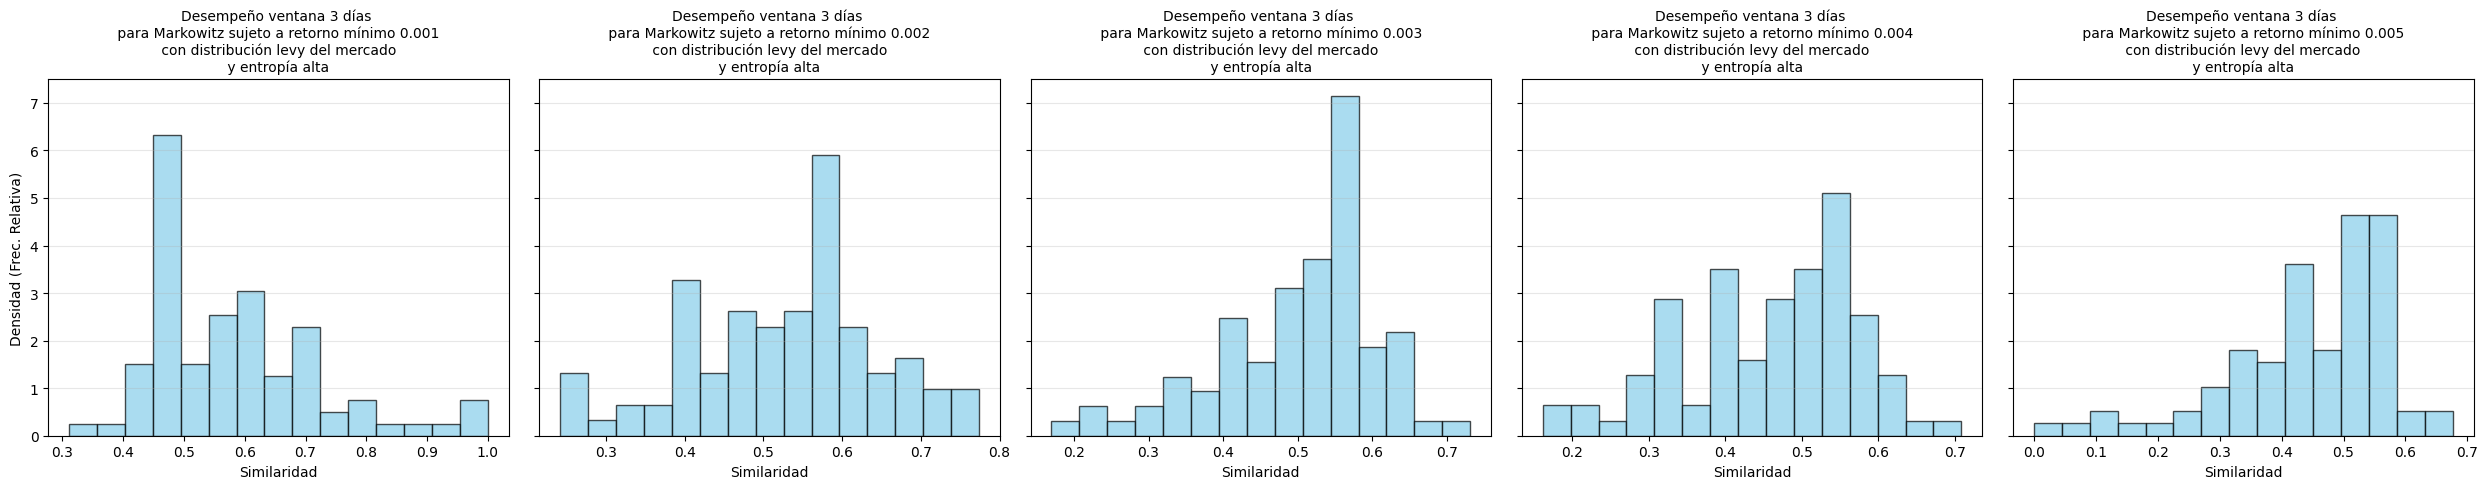

In [13]:
# 1. Configuración de la grilla (Forzada a 1 fila de 5 columnas)
modelos = df_similaridad_total_v3.columns
n_modelos = len(modelos)
n_cols = 5  # Cambiado a 5 para que entren todos en una fila
n_rows = 1  # Forzado a 1 renglón

# 2. Crear la figura y los subplots
# He aumentado el ancho (25) para que los 5 gráficos tengan espacio
fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 5), sharey=True, sharex=False)

# 3. Bucle para generar cada histograma
for i, modelo in enumerate(modelos):
    # Si solo hay una fila, axes puede no ser una matriz, lo tratamos con cuidado
    ax = axes[i] if n_modelos > 1 else axes
    
    # Generar el histograma con densidad
    ax.hist(df_similaridad_total_v3[modelo], bins=15, color='skyblue', 
            edgecolor='black', alpha=0.7, density=True)
    
    # Configuración del título
    ax.set_title(f'Desempeño ventana 3 días \n para {modelo} \n con distribución levy del mercado \n y entropía alta ', fontsize=10)

    ax.set_xlabel('Similaridad')
    # Solo ponemos el label del eje Y en el primero para no saturar
    if i == 0:
        ax.set_ylabel('Densidad (Frec. Relativa)')
        
    ax.grid(axis='y', alpha=0.3)

# 4. Limpiar subplots vacíos (en caso de que haya menos de 5 modelos)
if n_modelos < n_cols:
    for j in range(i + 1, n_cols):
        fig.delaxes(axes[j])

# Ajustar espaciado
plt.tight_layout()
plt.show()

In [14]:
# =========================================================================
# === Definiciones 
# =========================================================================

# 1. Definición de Objetivos (idéntica a tu código)
objectives = [
    max, # 'stocks_number'
    min, # 'Cross_Entropy'
    max, # 'Zheng_Entropy'
    max, # 'Div_Ratio'
    min, # 'CV_MC'
    max, # 'PDI'
]

# 2. Identificar el nivel 'Ventana' que quieres filtrar (parece ser '3')
VENTANA_FILTRO = 5
LEVEL_VENTANA = 'Ventana'
LEVEL_CORRIDA = 'Corrida'

# 3. Filtrar por Ventana = 3 (esto simplifica la iteración)
df_ventana_5 = df_metricas_limpio[
    df_metricas_limpio.index.get_level_values(LEVEL_VENTANA) == VENTANA_FILTRO].copy()

# === PASO CRÍTICO: OBTENER LOS IDs DE CORRIDA REALES ===
# =========================================================================
# Obtenemos la lista ÚNICA de los identifi}cadores de corrida que existen 
corridas_existentes_v5 = df_ventana_3.index.get_level_values('Corrida').unique().tolist()
corridas_existentes_v5


[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 21,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 59,
 60,
 61,
 62,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 72,
 74,
 75,
 77,
 78,
 79,
 80,
 81,
 82,
 84,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99]

In [15]:
# Diccionario para almacenar las Matrices de Decisión generadas
matrices_decision = {}

# Iteramos sobre los IDs de corrida REALES (ej: '10', '11'...)
for el_corrida_id in corridas_existentes_v5:

    # 1. Filtramos el DataFrame de MÉTRICAS para la corrida actual
    df_filtrado = df_ventana_5[df_ventana_5.index.get_level_values('Corrida') == el_corrida_id].droplevel(['Ventana', 'Corrida'])
    
    # 2. ACCESO AL DATAFRAME ORIGINAL DE PESOS (Variable nueva solicitada)

    # === Extracción de elementos para skcriteria ===
    data = df_filtrado.to_numpy() 
    alternatives = df_filtrado.index 
    criteria = df_filtrado.columns 
    
    # === Generar la Matriz de Decisión ===
    dm = skc.mkdm(
        data, 
        objectives=objectives,
        alternatives=alternatives, 
        criteria=criteria
    )
    
    # Guardar la DM
    matrices_decision[el_corrida_id] = dm
matrices_decision[1]

/home/nadia/indicador/lib/python3.10/site-packages/pandas/io/formats/format.py:1354: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  for val, m in zip(values.ravel(), mask.ravel())
/home/nadia/indicador/lib/python3.10/site-packages/pandas/io/formats/format.py:1354: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  for val, m in zip(values.ravel(), mask.ravel())


,stocks_number[▲ 1.0],Cross_Entropy[▼ 1.0],Zheng_Entropy[▲ 1.0],Div_Ratio[▲ 1.0],CV_MC[▼ 1.0],PDI[▲ 1.0]
Markowitz sujeto a retorno mínimo 0.001,17.0,2.998522,1.945994,0.212773,1.367778,2.300099
Markowitz sujeto a retorno mínimo 0.002,9.0,0.510726,1.830331,0.169074,1.387817,1.776824
Markowitz sujeto a retorno mínimo 0.003,8.0,0.456309,1.721838,0.149463,1.498649,1.773964
Markowitz sujeto a retorno mínimo 0.004,7.0,0.453976,1.583071,0.138251,1.441538,1.767623
Markowitz sujeto a retorno mínimo 0.005,45.0,10.601702,1.486627,0.130317,4.300645,2.422106


In [16]:
# 1. Definición del Pipeline
pipe_igual_vector = pipeline.mkpipe(
    invert_objectives.NegateMinimize(),
    scalers.VectorScaler(target="matrix"),
    weighters.EqualWeighter(),
    similarity.TOPSIS(),
)
# VARIABLE NUEVA: Lista para acumular los resultados de similaridad
resultados_similaridad = []

for el_corrida_id in corridas_existentes_v3:
    
    # 1. Recuperamos la DM del diccionario generado anteriormente
    dm = matrices_decision[el_corrida_id]
    
    # 2. Ejecución del pipeline
    result_igual_vector = pipe_igual_vector.evaluate(dm)
    
    # === CORRECCIÓN DEL ERROR Y CAMBIO DE NOMBRE ===
    # Convertimos el array de numpy (result_igual_vector.e_.similarity) a DataFrame
    # Usamos las alternativas de la DM como nombres de columnas
    df_similaridad_parcial = pd.DataFrame(
        [result_igual_vector.e_.similarity], 
        columns=dm.alternatives, 
        index=[el_corrida_id]
    )
    
    # 3. Guardamos en la lista para concatenar después
    resultados_similaridad.append(df_similaridad_parcial)

# 4. CREACIÓN DEL DATAFRAME FINAL (VARIABLE NUEVA)
df_similaridad_total_v5 = pd.concat(resultados_similaridad)
df_similaridad_total_v5.index.name = 'Corrida'

# Visualizar resultado consolidado de similaridad
df_similaridad_total_v5

,Markowitz sujeto a retorno mínimo 0.001,Markowitz sujeto a retorno mínimo 0.002,Markowitz sujeto a retorno mínimo 0.003,Markowitz sujeto a retorno mínimo 0.004,Markowitz sujeto a retorno mínimo 0.005
Corrida,,,,,
1,0.612591,0.593140,0.579977,0.571482,0.410286
2,0.863610,0.711529,0.229472,0.766478,0.741650
3,0.404002,0.640727,0.622939,0.594202,0.583933
4,0.379932,0.657387,0.469668,0.622022,0.607909
5,0.523036,0.622082,0.532338,0.505190,0.462126
...,...,...,...,...,...
95,0.633008,0.685243,0.637038,0.634712,0.320943
96,0.601891,0.393243,0.388584,0.363637,0.394733
97,0.442921,0.514407,0.544139,0.547841,0.546184


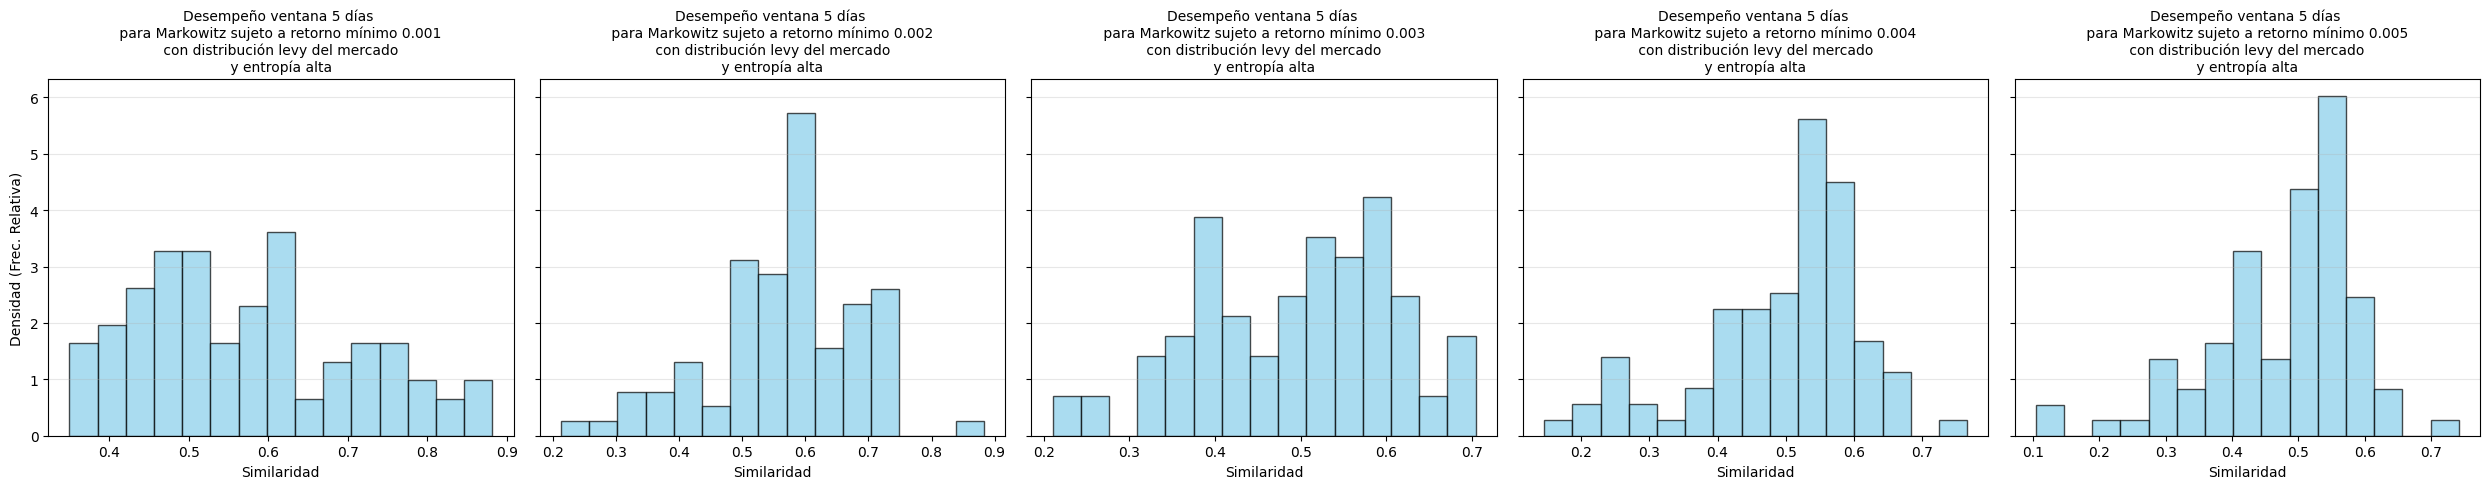

In [17]:
# 1. Configuración de la grilla (Forzada a 1 fila de 5 columnas)
modelos = df_similaridad_total_v5.columns
n_modelos = len(modelos)
n_cols = 5  # Cambiado a 5 para que entren todos en una fila
n_rows = 1  # Forzado a 1 renglón

# 2. Crear la figura y los subplots
# He aumentado el ancho (25) para que los 5 gráficos tengan espacio
fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 5), sharey=True, sharex=False)

# 3. Bucle para generar cada histograma
for i, modelo in enumerate(modelos):
    # Si solo hay una fila, axes puede no ser una matriz, lo tratamos con cuidado
    ax = axes[i] if n_modelos > 1 else axes
    
    # Generar el histograma con densidad
    ax.hist(df_similaridad_total_v5[modelo], bins=15, color='skyblue', 
            edgecolor='black', alpha=0.7, density=True)
    
    # Configuración del título
    ax.set_title(f'Desempeño ventana 5 días \n para {modelo} \n con distribución levy del mercado \n y entropía alta ', fontsize=10)

    ax.set_xlabel('Similaridad')
    # Solo ponemos el label del eje Y en el primero para no saturar
    if i == 0:
        ax.set_ylabel('Densidad (Frec. Relativa)')
        
    ax.grid(axis='y', alpha=0.3)

# 4. Limpiar subplots vacíos (en caso de que haya menos de 5 modelos)
if n_modelos < n_cols:
    for j in range(i + 1, n_cols):
        fig.delaxes(axes[j])

# Ajustar espaciado
plt.tight_layout()
plt.show()

In [18]:
# =========================================================================
# === Definiciones 
# =========================================================================

# 1. Definición de Objetivos (idéntica a tu código)
objectives = [
    max, # 'stocks_number'
    min, # 'Cross_Entropy'
    max, # 'Zheng_Entropy'
    max, # 'Div_Ratio'
    min, # 'CV_MC'
    max, # 'PDI'
]

# 2. Identificar el nivel 'Ventana' que quieres filtrar (parece ser '3')
VENTANA_FILTRO = 7
LEVEL_VENTANA = 'Ventana'
LEVEL_CORRIDA = 'Corrida'

# 3. Filtrar por Ventana = 3 (esto simplifica la iteración)
df_ventana_7 = df_metricas_limpio[
    df_metricas_limpio.index.get_level_values(LEVEL_VENTANA) == VENTANA_FILTRO].copy()

# === PASO CRÍTICO: OBTENER LOS IDs DE CORRIDA REALES ===
# =========================================================================
# Obtenemos la lista ÚNICA de los identifi}cadores de corrida que existen 
corridas_existentes_v7 = df_ventana_3.index.get_level_values('Corrida').unique().tolist()
corridas_existentes_v7

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 21,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 59,
 60,
 61,
 62,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 72,
 74,
 75,
 77,
 78,
 79,
 80,
 81,
 82,
 84,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99]

In [19]:
# Diccionario para almacenar las Matrices de Decisión generadas
matrices_decision = {}

# Iteramos sobre los IDs de corrida REALES (ej: '10', '11'...)
for el_corrida_id in corridas_existentes_v5:

    # 1. Filtramos el DataFrame de MÉTRICAS para la corrida actual
    df_filtrado = df_ventana_7[df_ventana_7.index.get_level_values('Corrida') == el_corrida_id].droplevel(['Ventana', 'Corrida'])
    
    # 2. ACCESO AL DATAFRAME ORIGINAL DE PESOS (Variable nueva solicitada)

    # === Extracción de elementos para skcriteria ===
    data = df_filtrado.to_numpy() 
    alternatives = df_filtrado.index 
    criteria = df_filtrado.columns 
    
    # === Generar la Matriz de Decisión ===
    dm = skc.mkdm(
        data, 
        objectives=objectives,
        alternatives=alternatives, 
        criteria=criteria
    )
    
    # Guardar la DM
    matrices_decision[el_corrida_id] = dm
matrices_decision[1]

/home/nadia/indicador/lib/python3.10/site-packages/pandas/io/formats/format.py:1354: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  for val, m in zip(values.ravel(), mask.ravel())
/home/nadia/indicador/lib/python3.10/site-packages/pandas/io/formats/format.py:1354: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  for val, m in zip(values.ravel(), mask.ravel())


,stocks_number[▲ 1.0],Cross_Entropy[▼ 1.0],Zheng_Entropy[▲ 1.0],Div_Ratio[▲ 1.0],CV_MC[▼ 1.0],PDI[▲ 1.0]
Markowitz sujeto a retorno mínimo 0.001,51.0,7.942343,2.318917,0.234745,3.214864,2.150138
Markowitz sujeto a retorno mínimo 0.002,13.0,0.743724,2.159272,0.179341,1.974401,1.708309
Markowitz sujeto a retorno mínimo 0.003,10.0,0.336858,1.960692,0.152903,1.763825,1.705565
Markowitz sujeto a retorno mínimo 0.004,7.0,0.375911,1.593624,0.137248,1.402991,1.673231
Markowitz sujeto a retorno mínimo 0.005,7.0,0.309217,1.618669,0.131234,1.475036,1.673231


In [20]:
# 1. Definición del Pipeline
pipe_igual_vector = pipeline.mkpipe(
    invert_objectives.NegateMinimize(),
    scalers.VectorScaler(target="matrix"),
    weighters.EqualWeighter(),
    similarity.TOPSIS(),
)
# VARIABLE NUEVA: Lista para acumular los resultados de similaridad
resultados_similaridad = []

for el_corrida_id in corridas_existentes_v3:
    
    # 1. Recuperamos la DM del diccionario generado anteriormente
    dm = matrices_decision[el_corrida_id]
    
    # 2. Ejecución del pipeline
    result_igual_vector = pipe_igual_vector.evaluate(dm)
    
    # === CORRECCIÓN DEL ERROR Y CAMBIO DE NOMBRE ===
    # Convertimos el array de numpy (result_igual_vector.e_.similarity) a DataFrame
    # Usamos las alternativas de la DM como nombres de columnas
    df_similaridad_parcial = pd.DataFrame(
        [result_igual_vector.e_.similarity], 
        columns=dm.alternatives, 
        index=[el_corrida_id]
    )
    
    # 3. Guardamos en la lista para concatenar después
    resultados_similaridad.append(df_similaridad_parcial)

# 4. CREACIÓN DEL DATAFRAME FINAL (VARIABLE NUEVA)
df_similaridad_total_v7 = pd.concat(resultados_similaridad)
df_similaridad_total_v7.index.name = 'Corrida'

# Visualizar resultado consolidado de similaridad
df_similaridad_total_v7

,Markowitz sujeto a retorno mínimo 0.001,Markowitz sujeto a retorno mínimo 0.002,Markowitz sujeto a retorno mínimo 0.003,Markowitz sujeto a retorno mínimo 0.004,Markowitz sujeto a retorno mínimo 0.005
Corrida,,,,,
1,0.459270,0.567251,0.557989,0.540225,0.539600
2,0.479526,0.555370,0.413901,0.484396,0.543167
3,0.513648,0.479048,0.526519,0.516413,0.204917
4,0.302535,0.792666,0.790395,0.693021,0.300833
5,0.403362,0.663644,0.609181,0.583659,0.584237
...,...,...,...,...,...
95,0.893653,0.656477,0.332279,0.100029,0.596938
96,0.498804,0.524346,0.423763,0.475619,0.509299
97,0.451753,0.664918,0.580694,0.578971,0.542287


In [21]:
# 1. Definición del Pipeline
pipe_igual_vector = pipeline.mkpipe(
    invert_objectives.NegateMinimize(),
    scalers.VectorScaler(target="matrix"),
    weighters.EqualWeighter(),
    similarity.TOPSIS(),
)
# VARIABLE NUEVA: Lista para acumular los resultados de similaridad
resultados_similaridad = []

for el_corrida_id in corridas_existentes_v3:
    
    # 1. Recuperamos la DM del diccionario generado anteriormente
    dm = matrices_decision[el_corrida_id]
    
    # 2. Ejecución del pipeline
    result_igual_vector = pipe_igual_vector.evaluate(dm)
    
    # === CORRECCIÓN DEL ERROR Y CAMBIO DE NOMBRE ===
    # Convertimos el array de numpy (result_igual_vector.e_.similarity) a DataFrame
    # Usamos las alternativas de la DM como nombres de columnas
    df_similaridad_parcial = pd.DataFrame(
        [result_igual_vector.e_.similarity], 
        columns=dm.alternatives, 
        index=[el_corrida_id]
    )
    
    # 3. Guardamos en la lista para concatenar después
    resultados_similaridad.append(df_similaridad_parcial)

# 4. CREACIÓN DEL DATAFRAME FINAL (VARIABLE NUEVA)
df_similaridad_total_v7 = pd.concat(resultados_similaridad)
df_similaridad_total_v7.index.name = 'Corrida'

# Visualizar resultado consolidado de similaridad
df_similaridad_total_v7

,Markowitz sujeto a retorno mínimo 0.001,Markowitz sujeto a retorno mínimo 0.002,Markowitz sujeto a retorno mínimo 0.003,Markowitz sujeto a retorno mínimo 0.004,Markowitz sujeto a retorno mínimo 0.005
Corrida,,,,,
1,0.459270,0.567251,0.557989,0.540225,0.539600
2,0.479526,0.555370,0.413901,0.484396,0.543167
3,0.513648,0.479048,0.526519,0.516413,0.204917
4,0.302535,0.792666,0.790395,0.693021,0.300833
5,0.403362,0.663644,0.609181,0.583659,0.584237
...,...,...,...,...,...
95,0.893653,0.656477,0.332279,0.100029,0.596938
96,0.498804,0.524346,0.423763,0.475619,0.509299
97,0.451753,0.664918,0.580694,0.578971,0.542287


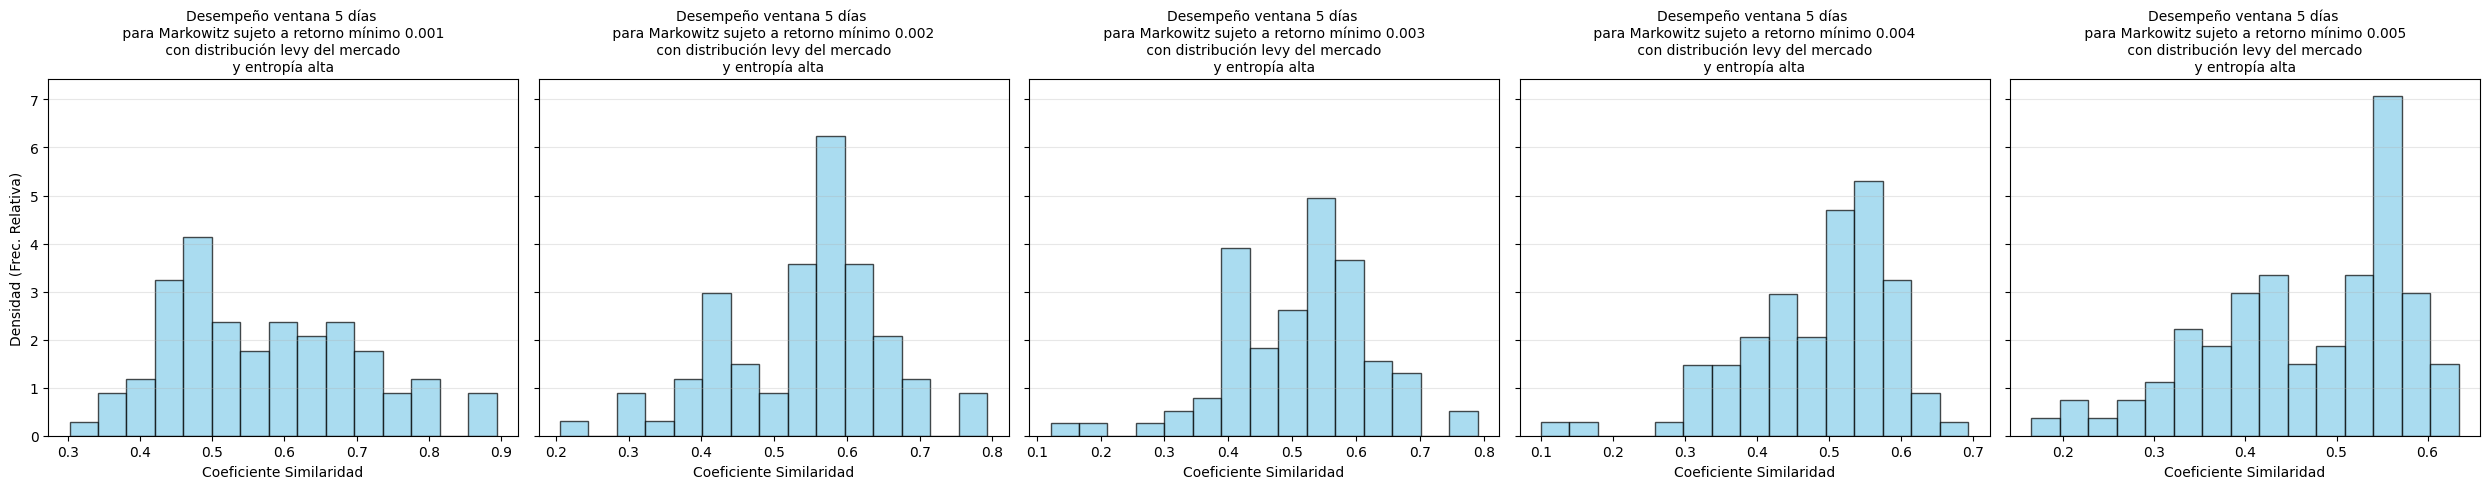

In [26]:
# 1. Configuración de la grilla (Forzada a 1 fila de 5 columnas)
modelos = df_similaridad_total_v7.columns
n_modelos = len(modelos)
n_cols = 5  # Cambiado a 5 para que entren todos en una fila
n_rows = 1  # Forzado a 1 renglón

# 2. Crear la figura y los subplots
# He aumentado el ancho (25) para que los 5 gráficos tengan espacio
fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 5), sharey=True, sharex=False)

# 3. Bucle para generar cada histograma
for i, modelo in enumerate(modelos):
    # Si solo hay una fila, axes puede no ser una matriz, lo tratamos con cuidado
    ax = axes[i] if n_modelos > 1 else axes
    
    # Generar el histograma con densidad
    ax.hist(df_similaridad_total_v7[modelo], bins=15, color='skyblue', 
            edgecolor='black', alpha=0.7, density=True)
    
    # Configuración del título
    ax.set_title(f'Desempeño ventana 5 días \n para {modelo} \n con distribución levy del mercado \n y entropía alta ', fontsize=10)

    ax.set_xlabel('Coeficiente Similaridad')
    # Solo ponemos el label del eje Y en el primero para no saturar
    if i == 0:
        ax.set_ylabel('Densidad (Frec. Relativa)')
        
    ax.grid(axis='y', alpha=0.3)

# 4. Limpiar subplots vacíos (en caso de que haya menos de 5 modelos)
if n_modelos < n_cols:
    for j in range(i + 1, n_cols):
        fig.delaxes(axes[j])

# Ajustar espaciado
plt.tight_layout()
plt.show()

/tmp/ipykernel_13156/122036564.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(df_similaridad_total_v3.columns, rotation=90)
/tmp/ipykernel_13156/122036564.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(df_similaridad_total_v5.columns, rotation=90)
/tmp/ipykernel_13156/122036564.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(df_similaridad_total_v7.columns, rotation=90)


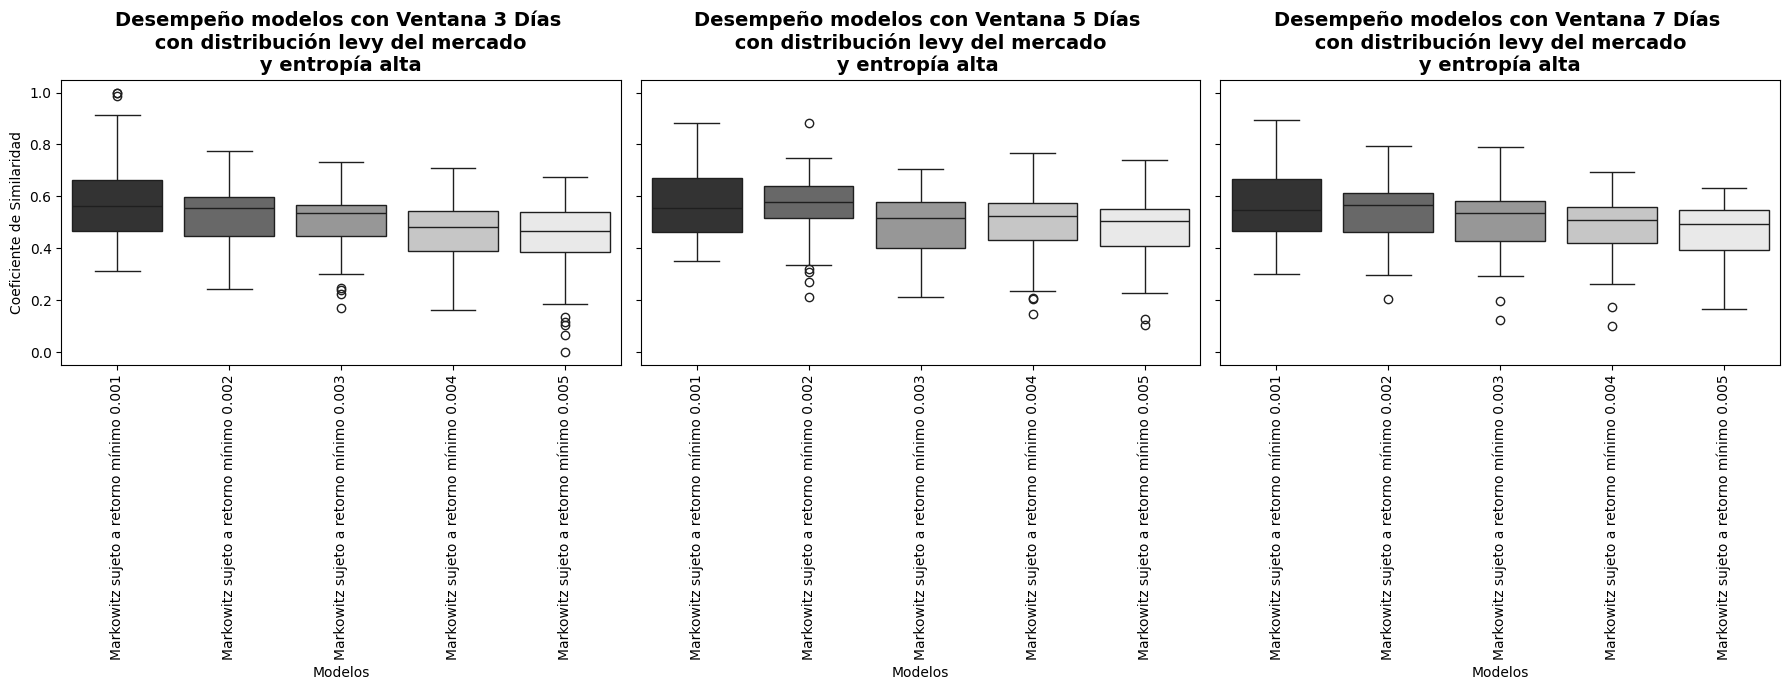

In [23]:


# 1. Configuración de la figura: 1 fila, 2 columnas
fig, axes = plt.subplots(1, 3, figsize=(18, 7), sharey=True)

# 2. Gráfico 1: Ventana 3 días
sns.boxplot(
    data=df_similaridad_total_v3, 
    ax=axes[0], 
    palette="Greys_r"
)
axes[0].set_title('Desempeño modelos con Ventana 3 Días \n con distribución levy del mercado \n y entropía baja ', fontsize=14, fontweight='bold')
axes[0].set_xticklabels(df_similaridad_total_v3.columns, rotation=90)
axes[0].set_ylabel('Coeficiente de Similaridad')
axes[0].set_xlabel('Modelos')

# 3. Gráfico 2: Ventana 5 días
sns.boxplot(
    data=df_similaridad_total_v5, 
    ax=axes[1], 
    palette="Greys_r"
)
axes[1].set_title('Desempeño modelos con Ventana 5 Días \n con distribución levy del mercado \n y entropía alta  ', fontsize=14, fontweight='bold')
axes[1].set_xticklabels(df_similaridad_total_v5.columns, rotation=90)
axes[1].set_ylabel('') # Quitamos el label porque comparten eje Y
axes[1].set_xlabel('Modelos')

# 3. Gráfico 3: Ventana 5 días
sns.boxplot(
    data=df_similaridad_total_v7, 
    ax=axes[2], 
    palette="Greys_r"
)
axes[2].set_title('Desempeño modelos con Ventana 7 Días \n con distribución levy del mercado \n y entropía alta ', fontsize=14, fontweight='bold')
axes[2].set_xticklabels(df_similaridad_total_v7.columns, rotation=90)
axes[2].set_ylabel('') # Quitamos el label porque comparten eje Y
axes[2].set_xlabel('Modelos')


# Ajustes finales
plt.tight_layout()
plt.show()

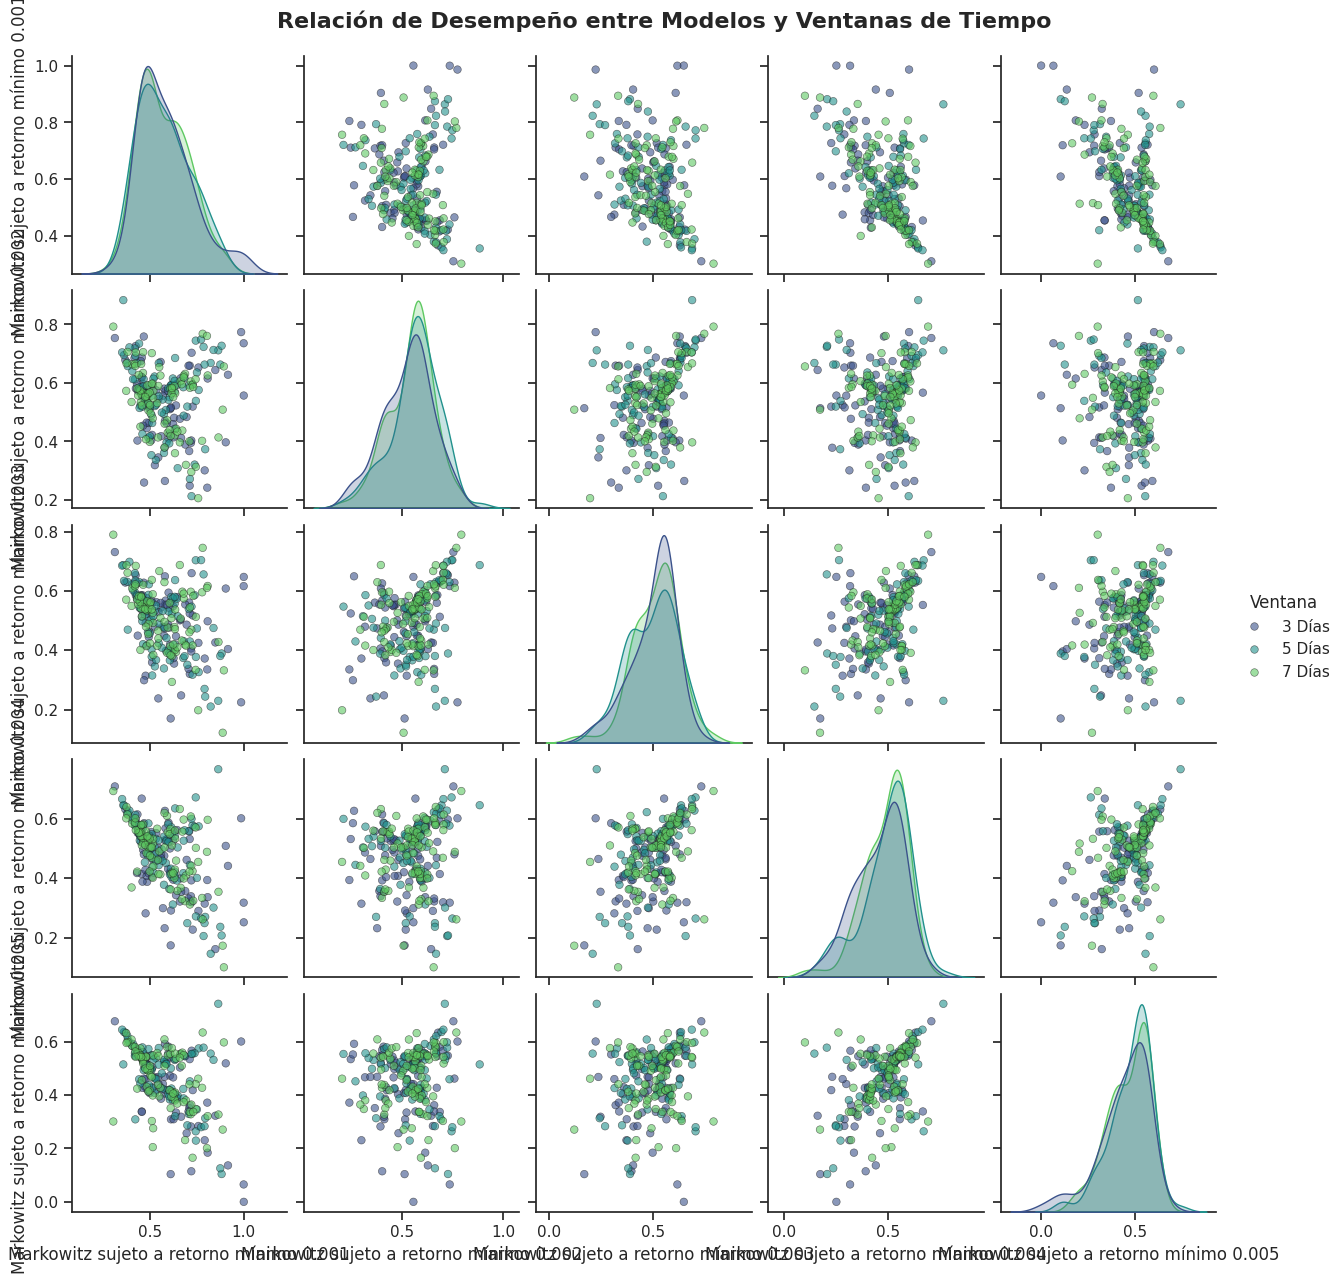

In [29]:
# 1. Preparación: Añadimos la etiqueta de "Ventana" a cada DataFrame
# Hacemos una copia para no modificar los originales
df3 = df_similaridad_total_v3.copy()
df5 = df_similaridad_total_v5.copy()
df7 = df_similaridad_total_v7.copy()

df3['Ventana'] = '3 Días'
df5['Ventana'] = '5 Días'
df7['Ventana'] = '7 Días'

# 2. Concatenamos los tres DataFrames en uno solo
df_total = pd.concat([df3, df5, df7], ignore_index=True)

# 3. Configuración del estilo
sns.set_theme(style="ticks")

# 4. Creación del Pairplot
# El 'hue' será la Ventana. Esto comparará cómo correlacionan los modelos entre sí
# y mostrará la distribución (KDE) en la diagonal.
g = sns.pairplot(
    df_total, 
    hue="Ventana", 
    palette="viridis", 
    diag_kind="kde",
    plot_kws={'alpha': 0.6, 's': 30, 'edgecolor': 'k'}, # Ajustes para los puntos
    height=2.5
)

# Añadir título general
g.fig.suptitle('Relación de Desempeño entre Modelos y Ventanas de Tiempo', y=1.02, fontsize=16, fontweight='bold')

plt.show()

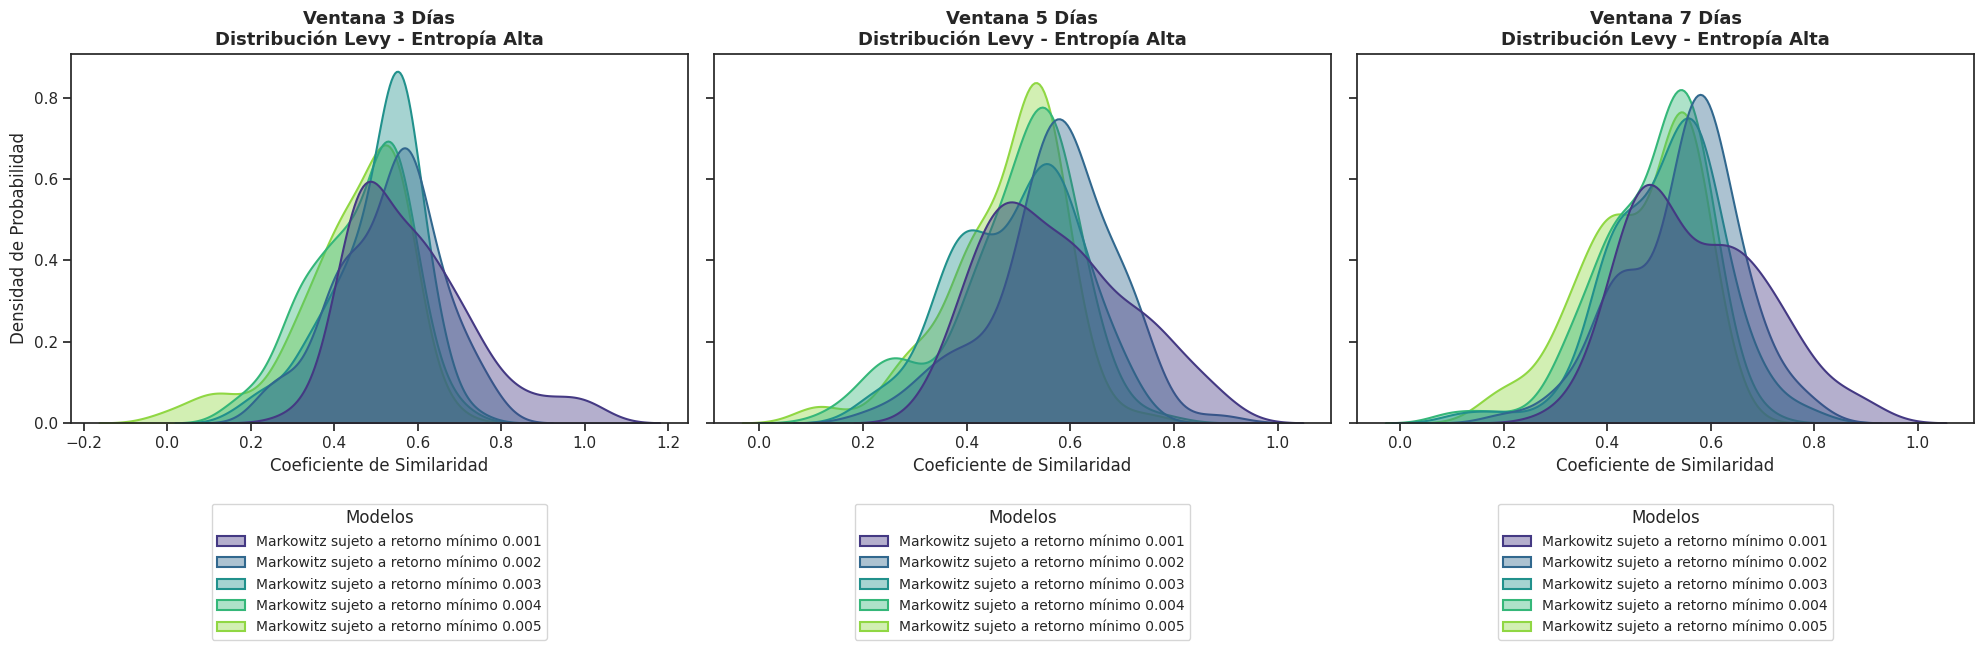

In [32]:
# 1. Configuración de la figura: 1 fila, 3 columnas
fig, axes = plt.subplots(1, 3, figsize=(20, 7), sharey=True)

# Lista de dataframes y sus títulos correspondientes
dfs = [df_similaridad_total_v3, df_similaridad_total_v5, df_similaridad_total_v7]
titulos = [
    'Ventana 3 Días\nDistribución Levy - Entropía Alta',
    'Ventana 5 Días\nDistribución Levy - Entropía Alta',
    'Ventana 7 Días\nDistribución Levy - Entropía Alta'
]

# 2. Iterar sobre los ejes y los datos para generar los KDEs
for i, df in enumerate(dfs):
    # Convertimos de formato ancho a largo para que Seaborn reconozca los modelos como categorías
    df_long = df.melt(var_name='Modelo', value_name='Similaridad')
    
    sns.kdeplot(
        data=df_long,
        x="Similaridad",
        hue="Modelo",
        fill=True,
        ax=axes[i],
        palette="viridis", # Una paleta colorida ayuda a diferenciar modelos
        alpha=0.4,
        linewidth=1.5
    )
    
    axes[i].set_title(titulos[i], fontsize=13, fontweight='bold')
    axes[i].set_xlabel('Coeficiente de Similaridad')
    
    # Solo el primer gráfico lleva etiqueta en el eje Y
    if i == 0:
        axes[i].set_ylabel('Densidad de Probabilidad')
    else:
        axes[i].set_ylabel('')

# 3. Ajustes de la leyenda para que no tape el gráfico si hay muchos modelos
for ax in axes:
    sns.move_legend(ax,  fontsize='small', title="Modelos",  loc='upper center', bbox_to_anchor=(0.5, -0.2))

# Ajustes finales
plt.tight_layout()
plt.show()

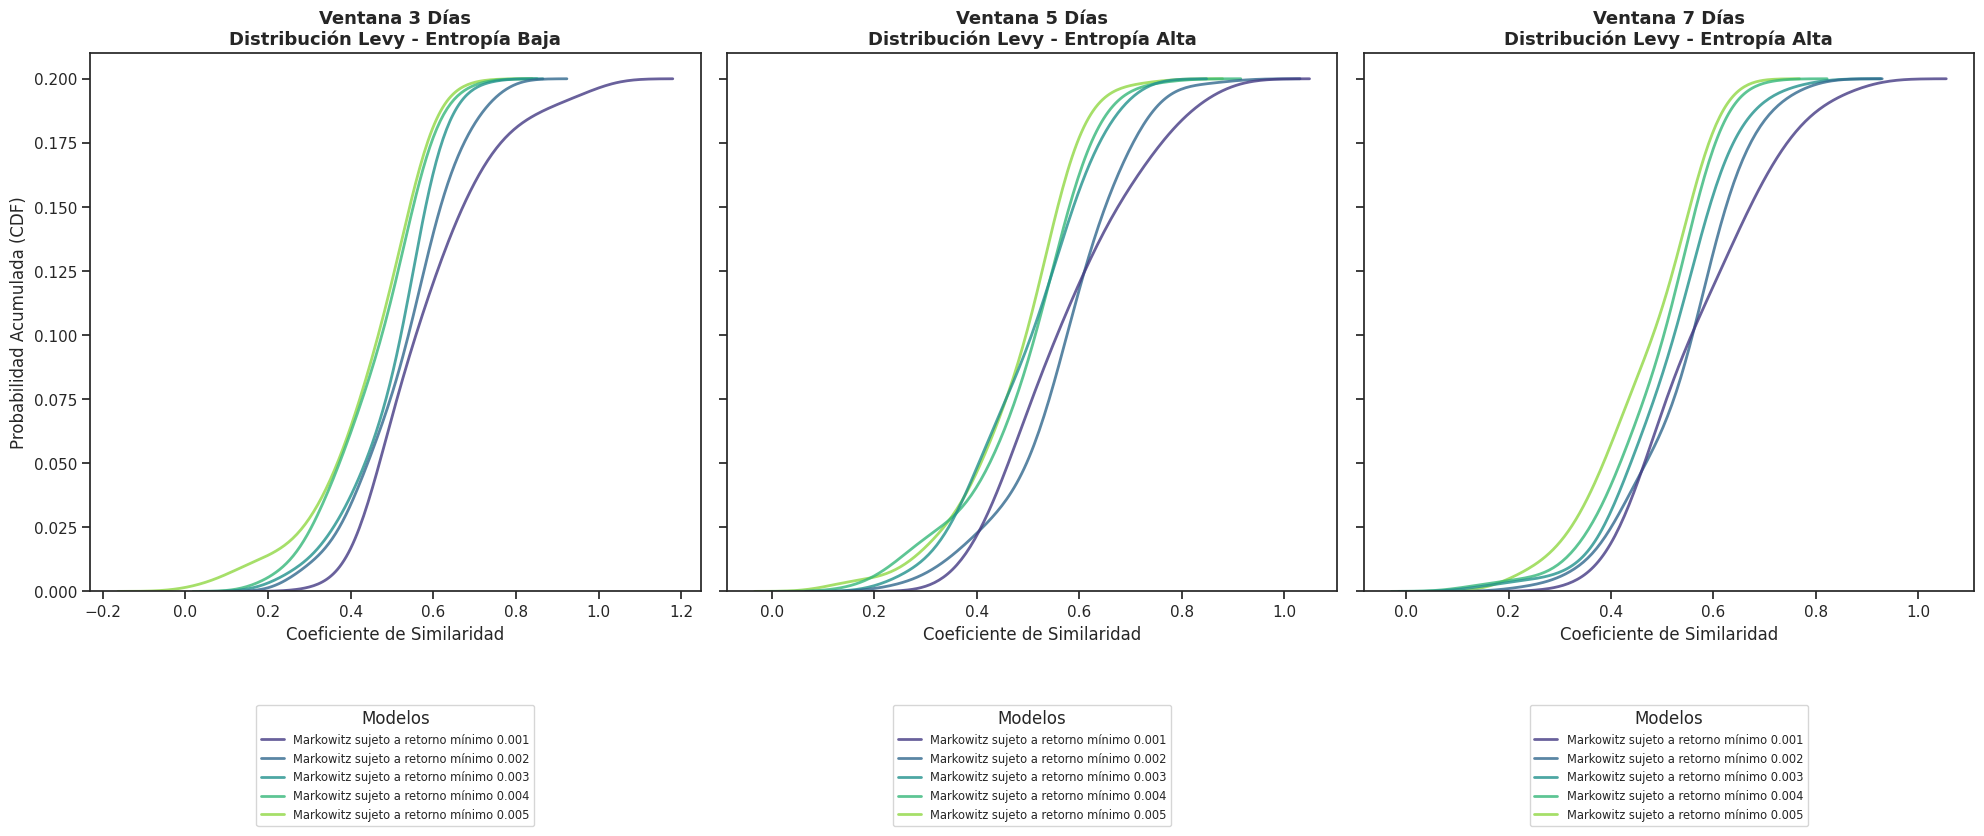

In [33]:
# 1. Configuración de la figura: 1 fila, 3 columnas
fig, axes = plt.subplots(1, 3, figsize=(20, 8), sharey=True)

# Lista de dataframes y sus títulos correspondientes
dfs = [df_similaridad_total_v3, df_similaridad_total_v5, df_similaridad_total_v7]
titulos = [
    'Ventana 3 Días\nDistribución Levy - Entropía Baja',
    'Ventana 5 Días\nDistribución Levy - Entropía Alta',
    'Ventana 7 Días\nDistribución Levy - Entropía Alta'
]

# 2. Iterar sobre los ejes y los datos para generar las distribuciones acumuladas
for i, df in enumerate(dfs):
    # Convertimos de formato ancho a largo
    df_long = df.melt(var_name='Modelo', value_name='Similaridad')
    
    sns.kdeplot(
        data=df_long,
        x="Similaridad",
        hue="Modelo",
        cumulative=True,     # Activamos la distribución acumulada
        fill=False,          # Solo mostramos la línea
        ax=axes[i],
        palette="viridis",
        linewidth=2,
        alpha=0.8
    )
    
    axes[i].set_title(titulos[i], fontsize=13, fontweight='bold')
    axes[i].set_xlabel('Coeficiente de Similaridad')
    
    if i == 0:
        axes[i].set_ylabel('Probabilidad Acumulada (CDF)')
    else:
        axes[i].set_ylabel('')

# 3. Ajustes de la leyenda abajo para no obstruir las líneas
for ax in axes:
    sns.move_legend(
        ax, 
        loc='upper center', 
        bbox_to_anchor=(0.5, -0.2), 
        ncol=1,             # Agrupamos en 5 columnas para que sea legible
        fontsize='x-small', 
        title="Modelos"
    )

# Ajustes finales de espaciado
plt.tight_layout()
plt.subplots_adjust(bottom=0.25) # Espacio para la leyenda
plt.show()